# Custom NER with spaCy

This notebook shows how to train a custom NER model with spaCy on the command line.

The Python library [spaCy](https://spacy.io) provides ***"industrial-strength natural language processing"***  covering
- **15 languages** with small-, medium- or large-scale language models
- the **full NLP pipeline** starting with tokenization over word embeddings to part-of-speech tagging and parsing
- many NLP **tasks** like classification, similarity estimation or named entity recognition

We will use it on the command line to

- **convert** the data into a form useable by spaCy,
- **check** the data for problems,
- **train** a custom NER model on our training data,
- **evaluate** this model on the validation data.

But first we need to download a [**language model**](https://spacy.io/models) to be used:

In [1]:
!python -m spacy download de_core_news_sm

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')


This language model contains the steps of a full NLP pipeline: 

![](img/spacy-pipeline.svg)


## Convert and check the data

 We **convert** the files to the format required by spaCy...

In [2]:
!mkdir -p ../data/02_train
!python -m spacy convert --converter ner ../data/01_raw/bag.conll ../data/02_train
!mkdir -p ../data/03_val
!python -m spacy convert --converter ner ../data/01_raw/bgh.conll ../data/03_val

ℹ Auto-detected token-per-line NER format
ℹ Grouping every 1 sentences into a document.
⚠ To generate better training data, you may want to group sentences
into documents with `-n 10`.
✔ Generated output file (12791 documents):
../data/02_train/bag.json
ℹ Auto-detected token-per-line NER format
ℹ Grouping every 1 sentences into a document.
⚠ To generate better training data, you may want to group sentences
into documents with `-n 10`.
✔ Generated output file (5858 documents): ../data/03_val/bgh.json


 ... and **check** the data for potential problems:

In [3]:
!python -m spacy debug-data de ../data/02_train ../data/03_val -p ner -b de_core_news_md


=========================== Data format validation ===========================
✔ Corpus is loadable

=============================== Training stats ===============================
Training pipeline: ner
Starting with base model 'de_core_news_md'
12791 training docs
5858 evaluation docs
⚠ 16 training examples also in evaluation data

============================== Vocab & Vectors ==============================
ℹ 343065 total words in the data (19175 unique)
ℹ 20000 vectors (500000 unique keys, 300 dimensions)
⚠ 16937 words in training data without vectors (0.05%)

========================== Named Entity Recognition ==========================
ℹ 17 new labels, 2 existing labels
0 missing values (tokens with '-' label)
⚠ 2 entity span(s) with punctuation
⚠ Low number of examples for new label 'LDS' (28)
⚠ Low number of examples for new label 'STR' (7)
⚠ Low number of examples for new label 'MRK' (1)
⚠ Low number of examples for new label 'AN' (2)
✔ Examples without occurrences available f

 Some tags occur extremely rarely so we can't expect the model to learn them very well.
 
 Moreover, we see that the language model knows almost all words occuring in the dataset, which may come as a surprise.

## Train the NER model

 We **train** the NER component of our language model as follows:

In [4]:
!rm -rf ../data/04_models/*
!python -m spacy train de ../data/04_models ../data/02_train/ ../data/03_val --base-model de_core_news_sm --pipeline 'ner' -n 5 -R

Training pipeline: ['ner']
Starting with base model 'de_core_news_sm'
Replacing component from base model 'ner'
Counting training words (limit=0)

Itn  NER Loss   NER P   NER R   NER F   Token %  CPU WPS
---  ---------  ------  ------  ------  -------  -------
  1  24603.289  70.126  55.900  62.210  100.000    13455                        
  2  11915.942  70.812  57.824  63.662  100.000    13340                        
  3   8104.641  69.880  58.422  63.640  100.000    32314                        
  4   6752.642  70.722  59.277  64.496  100.000    32668                        
  5   5325.904  71.152  59.791  64.979  100.000    33109                        
✔ Saved model to output directory
../data/04_models/model-final
✔ Created best model
../data/04_models/model-best


This command tells spaCy to train a new model

- for the German language whose code is `de`
- saving the trained model in `../data/04_models`
- using the training and validation data in `../data/02_train` and `../data/03_val`, respectively,
- starting from the base model `de_core_news_sm`
- where the task to be trained is `ner` --- named entity recognition
- replacing the standard named entity recognition component via `-R`
- using 5 epochs, that is, 5 runs over the entire training data.

In case you have an NVidia GPU with CUDA set up, you can try to speed up the training, see spaCy's [installation](https://spacy.io/usage#gpu) and [training](https://spacy.io/api/cli#train) instructions.

## Evaluate the NER model

 Finally, we **evaluate** the model on the validation data:

In [5]:
!python -m spacy evaluate ../data/04_models/model-best ../data/03_val


================================== Results ==================================

Time      5.40 s
Words     177835
Words/s   32950 
TOK       100.00
POS       0.00  
UAS       0.00  
LAS       0.00  
NER P     71.15 
NER R     59.79 
NER F     64.98 
Textcat   0.00  



This outputs the precision, recall and F1-score for the NER task (NER P, NER R, NER F).

The overall performance looks moderate. For better results, one could use

1. the medium or large language model `de_core_news_md` or `de_core_news_lg`, respectively
2. more training steps
3. more training data (we only used a subset of the dataset).

Here, the problem is not the model but the data: some tag categories appear very rarely so it's hard for the model learn them. For a more thorough evaluation, we need to see the scores for each tag category.

## Appendix 1: Use the NER model

To use our new model and to see how it performs on each annotation class, we need to use to the [Python API](https://spacy.io/api) of [spaCy](https://spacy.io). Let us  **load** the best trained model version:

In [6]:
import spacy
MODEL_PATH = '../data/04_models/model-best'
nlp = spacy.load(MODEL_PATH)

It can  be **applied** to detect entities in new text [as follow](https://spacy.io/usage/linguistic-features#named-entities-101):

In [7]:
sample = """Trotz der zweifelhaften Bewertung von MDMA als "harte Droge"
( vgl. BGH , Beschluss vom 3. Februar 1999 - 5 StR 705/98 ,
juris Rn. 2 ; zum Meinungsstand Patzak in Körner / Patzak / Volkmer
, BtMG , 8. Aufl. , Vorbem. zu §§ 29 ff. Rn. 213 mwN ; Weber , BtMG ,
5. Aufl. , § 1 Rn. 364 mwN ) hat der Strafausspruch Bestand ,
da die verhängte Rechtsfolge jedenfalls angemessen ist 
(§ 354 Abs. 1a Satz 1 StPO) ."""

doc = nlp(sample)

for ent in doc.ents:
    print(ent.label_, ':', ent.text)

RS : BGH , Beschluss vom 3. Februar 1999 - 5 StR 705/98
ORG : Meinungsstand Patzak in Körner / Patzak / Volkmer
LIT : Weber , BtMG ,
5. Aufl. , § 1 Rn. 364
GS : § 354 Abs. 1a Satz 1 StPO


## Appendix 2: Analyse the model performance

To obtain scores for the model on the level of annotation classes, we load the validation data:

In [8]:
from spacy.gold import GoldCorpus

VAL_FILENAME = '../data/03_val/bgh.json'


val_corpus = GoldCorpus(VAL_FILENAME, VAL_FILENAME)
docs_golds = list(val_corpus.train_docs(nlp))
docs, golds = zip(*docs_golds)

To apply our model to these documents, we need to use only the NER component of the model's NLP pipeline:

In [9]:
ner =nlp.pipeline[0][1]
predictions = list(ner.pipe(docs))

Finally, we can evaluate the performance using the [`Scorer`](https://spacy.io/api/scorer) class. Along the way, we count how often each tag occured:

In [10]:
from spacy.scorer import Scorer
from collections import Counter

tag_counts = Counter()
scorer = Scorer()
for y_p, y_t in zip(predictions, golds):
    scorer.score(y_p, y_t)
    for tag in y_t.ner:
        tag_counts[tag.split('-')[-1]] += 1
print(scorer.ents_p, scorer.ents_r, scorer.ents_f)


71.15237852963622 59.79050876442924 64.97851086072714


These are the same scores that we obtained by validating on the command line. Additionally, the `ents_per_type` attribute of `scorer` gives us access to the tag-level scores. With pandas installed (`pip install pandas`), we can put these scores in a table as follows:

In [11]:
import pandas as pd

scores = (pd.DataFrame.from_dict(scorer.ents_per_type, orient='index')
                      .join(pd.Series(tag_counts, name='support'))
                      .sort_values(by='support', ascending=False))
scores

p          r          f  support
RS   72.831858  68.242123  70.462329    18615
GS   84.589892  83.143322  83.860370     7640
LIT  72.686230  78.921569  75.675676     4685
GRT  67.816092  20.557491  31.550802      662
RR   99.308756  77.101968  86.807654      560
EUN  34.000000  26.562500  29.824561      540
PER  70.909091   9.069767  16.082474      494
ORG  12.820513  14.285714  13.513514      176
VT    4.054054  25.000000   6.976744      150
INN  17.391304   8.000000  10.958904      124
UN   20.000000  16.393443  18.018018      122
LD   27.272727  34.177215  30.337079       95
ST   25.471698  33.750000  29.032258       85
VO   20.000000  10.000000  13.333333       81
MRK   0.000000   0.000000   0.000000       58
AN    0.000000   0.000000   0.000000       57
STR   0.000000   0.000000   0.000000       35
VS    0.000000   0.000000   0.000000       10
LDS   0.000000   0.000000   0.000000       10

Finally, let us visualize these scores.

<AxesSubplot:>

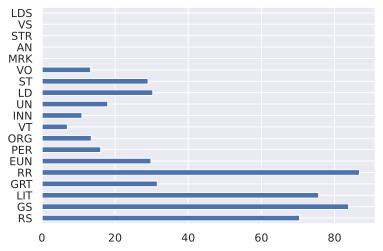

In [12]:
import seaborn as sns
import matplotlib.pyplot
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
sns.set()

scores['f'].plot.barh()

Plotting the F1-Score (`f`) versus the number of tokens with this tag shows a **correlation** between **poor performance** and **shortage of training data**:

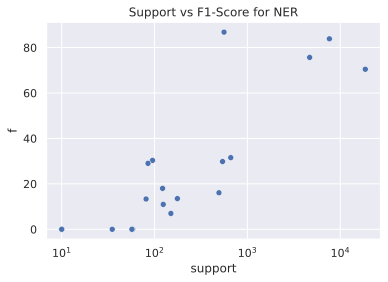

In [13]:
plot = sns.scatterplot(x='support', y='f', data=scores)
plot.set(xscale='log', title='Support vs F1-Score for NER')
plot.figure.savefig('support_f1.svg')